# The iris project: a multiclassification problem

We will use the famous iris dataset to build a model that determines the specie of an iris flower based on
specifics measured properties that we call features (petal length, width, etc.) that will be used to train a machine learning model .

The model we trained will be able to predict the species (the corrispondent class) for the new irises as we find them.

This is a supervised machine learning problem, because we already have measures about iris features for which we already know the species (so to say we already know the relationship between the input(s)=features measurement and the output=iris species).

The first step is to import all the libraries that we need .

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit  
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report      
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



## Load the database and explore it
Then we have to load the database and explore a little bit what's inside.

The first key that we see is data, it contains 150 iris flowers with 4 features encoded by different numerical values:
- sepal length (cm),
- sepal width (cm),
- petal length (cm),
- petal width (cm)).

The target key contains values of either 0 1 or 2 encoding the species (so the class we assigned to a flower)
es: the first flower specie is encoded by 0 it means it is a setosa, then we have versicolor ( class 1) and 
virginica(class 2).

How do i know it? because in the other key, that is target_names, the first element (so the zero term) is exactly setosa. 

So in target_names we will find the species names whose class corresponds to their idex in the array.

The other key that we see is DESCR that is simply a description of the dataset, so if we want to better see all the infos we can simply print iris.DESCR.


In [2]:
iris = load_iris()
print((iris.data).shape) #150 flowers with 4 features
print(iris.keys())
X, Y = iris.data, iris.target #here we associate x->the data and y-> corresponding class

(150, 4)
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


## load iris into panda dataframe 
We can also load the dataset into a panda dataframe so to have a better visualization.

In [3]:
class_names = iris.target_names
data1 = pd.DataFrame(data= np.c_[iris['data'],iris['target']],
                     columns= iris['feature_names'] + ['specie'])

D=dict(enumerate(iris.target_names))
D2 = {v: k for k, v in D.items()}
data1=data1.replace({"specie": D})
print(data1)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

        specie  
0       se

## Description of dataset
Moreover we used pandas and seaborn to plot the number of flowers for each specie and their percentage over the total dataset iris. 
As we can see, that the number of flowers for each class is the same (50 flowers for each class).

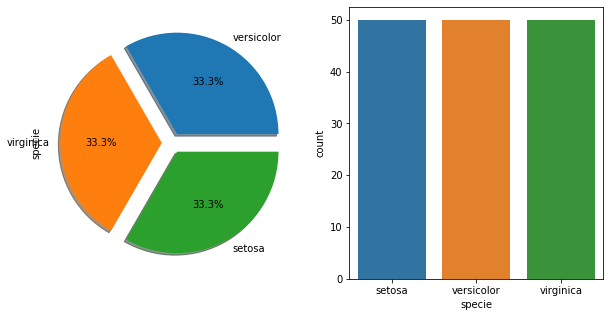

In [4]:
#we have to  count number of times a particular species has occurred. 
f,ax=plt.subplots(1,2,figsize=(10,5))
sns.countplot('specie',data=data1)
data1['specie'].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
plt.show()

Moreover we can use panda to discover the mean features values for each group (species):

In [5]:
#we can  count number of times a particular species has occurred:
#print(data1["specie"].value_counts())

#or display records only with a specific specie as "Iris-setosa".
#print(data1.loc[data1["specie"] == 'setosa'].describe())

#eventually print mean values for each species
data1.groupby("specie").mean()  #if we use .describe() we can have even more detail such as standard deviation

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
specie,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


## Feature selection
In order to select the parmeters for machine learning and avoid overfittig, we studied the correlation between all the features. 
### Pearson correlation
Is used to determine pairwise correlation of all the features of the dataset.
It measures the strength of association between two measures (es: association between petal length and width ) and the direction of the relationship.

The value of the correlation coefficient can assume values  between +1 and -1 (highlighting a strong relationship near 1).

NB: negative values near -1 show negative correlation

In [6]:
data1.corr(method='pearson') 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


### Pair plot 
In order to better visualize the the relationship between each feature we used a pairplot
( all variables paired with all the other variables.)

/home/maria/.anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


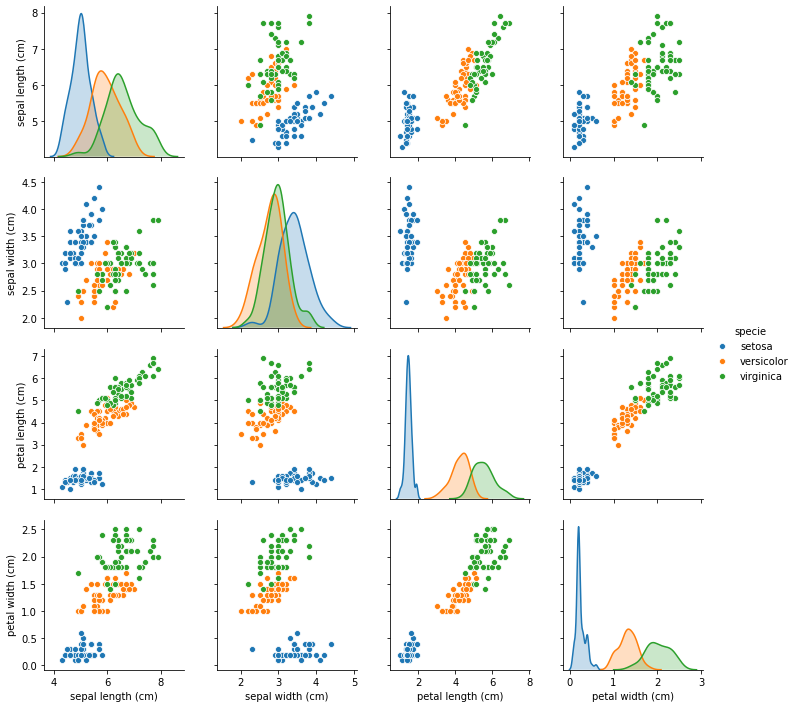

In [7]:
sns.pairplot(data1, hue='specie', height=2.5);
plt.show()

### Heat map 
is another method used to find out the correlation between different features in the dataset.

High positive value shows that the features have high correlation (high negative values show negative correlation).

Here the matrix underlines the high correlation between the features petal width and petal length .
Nevertheless we decided to mantain all the 4 features because: 
- The total amount of features is already small,
- The model can be trained fast enough with all the 4 features with high accuracy


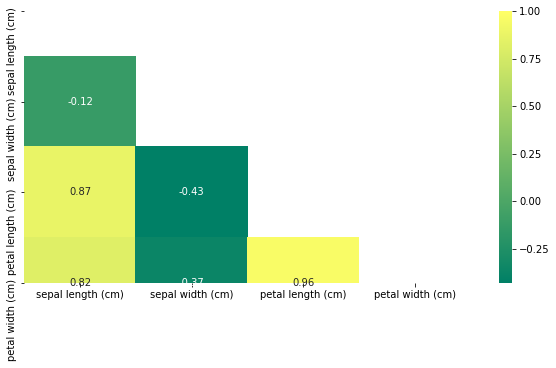

In [8]:
plt.figure(figsize=(10,5))
matrix = np.triu(data1.corr())
sns.heatmap(data1.corr(), annot=True, mask=matrix,cmap='summer')
plt.show()  

## Outliers identification
Is important because it can happen that an association is due to the presence of an outlier.
In order to identify outliers in the iris dataset we used the box plot. 
In the below plot we easly see the minimum, lower quartile (25th percentile), median (50th percentile), upper quartile (75th percentile), and a maximum of each feature. 
Here we decided to delete all the outliers so we ended up with 144 iris flower .

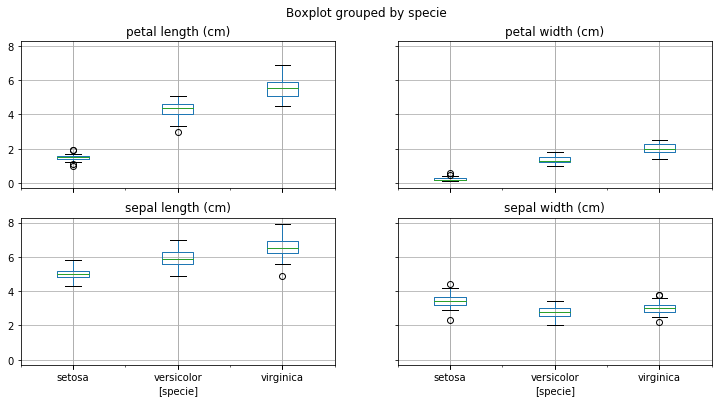

(144, 5)


In [9]:
data1.boxplot(by="specie", figsize=(12, 6))
plt.show() 
c = [x for x in data1.columns if x != 'specie']
#here we delete the outliers
for flower in class_names:
    df = data1[(data1["specie"] == flower)]
    for feature in c:
        Q1 =  df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        delete=df[(df[feature] < Q1-1.5*IQR ) | (df[feature] > Q3+1.5*IQR)][feature]
        if len(delete) != 0:
            data1=data1.drop([delete.index[0]])
        
print(data1.shape)

#here we renew the X and Y 
X=(data1.iloc[:, :-1]).to_numpy()
Y= [D2[classe] for classe in data1['specie'].values]



## Swarm and Violin plot combined
Shows all observations along with some representation of the underlying distribution.

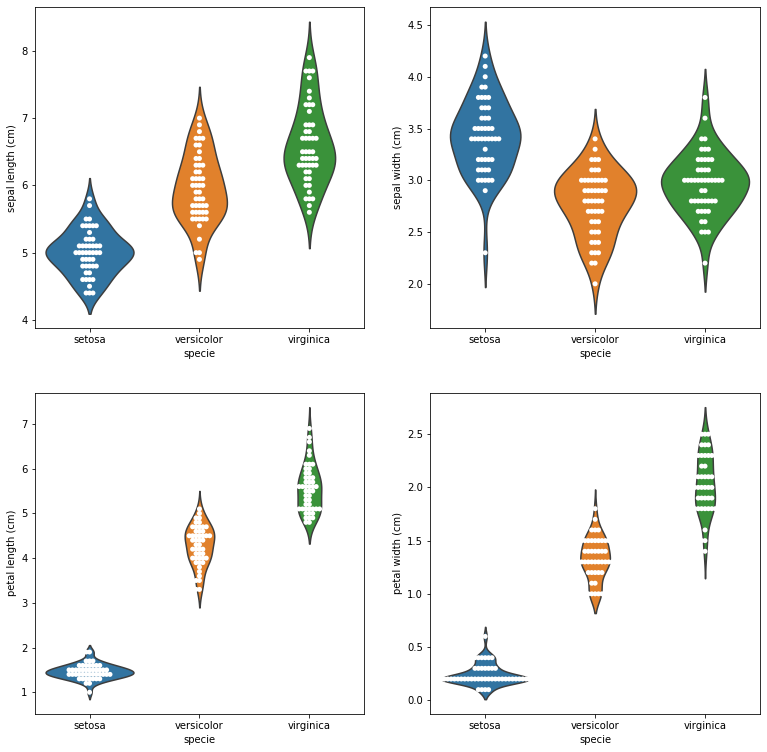

In [10]:
f,ax=plt.subplots(2,2,figsize=(20,20))
d={0:(0,0),1:(0,1),2:(1,0),3:(1,1)}
c = [x for x in data1.columns if x != 'specie']
for col in c:
    sns.violinplot(x="specie", y=col, data=data1, inner=None,ax=ax[d[c.index(col)][0]][d[c.index(col)][1]])
    sns.swarmplot(x="specie", y= col, data=data1,color="white", edgecolor="black",ax=ax[d[c.index(col)][0]][d[c.index(col)][1]])

sns.set(style="whitegrid")
fig=plt.gcf()
fig.set_size_inches(13,13)
plt.show()    


## Dataset splitting into training and test
We want to train a machine learning model that is able to correclty classify unseen before data. 
In order to do that we have to test the performance of our model using a dataset for which we already know the output (the corrispondent class).

Splitting the labelled data into two part we are now able compare the predicted class with the real label  .

We will test the performance on a fraction of our iris dataset that is called Test set , that here corresponds to a 25% of the total iris dataset.

In [11]:
test_size = 0.25
seed = 7          
X_train, X_test, Y_train, Y_test= train_test_split(X, Y,test_size=test_size,random_state=7)

### if we want to verify the split was properly done we can do:
test_size=(len(X_test)/(len(X_train)+len(X_test)))
print(test_size)

0.25


## Check for class imbalance
Our machine learning model needs to be trained with a training set in which the number of iris in each class is more or less the same. Therefore we checked that after the splitting of the dataset into trainig and test set, the class proportion is the same as before

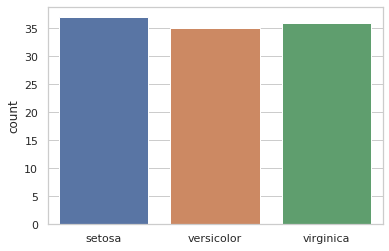

In [12]:
# visualize the target variable
g = sns.countplot(Y_train)
g.set_xticklabels(list(D.values()))
plt.show()


## Resampling
In order to evaluate if the model is suffering by bias or variance we take advantage of resampling procedures
(they estimate the performance of a model on unseen data).

Here we evaluated three different procedures:
- K-fold Cross-Validation,
- Leave One Out Cross-Validation,
- Shuffle Split Cross Validation.

Re-sampling procedures are useful to evaluate machine learning models on a limited data sample, their main goal is to test the model’s ability to predict new data that have not been used during the training, in order to avoid overfitting. 

It gives an idea on whether the produced model will be general enough to correctly predict an independent dataset (our test set, that has never been seen during the training procedure). 

The best overall accuracy with the lowest standard deviation has been obtained with the Shuffle Split procedure.

In [13]:
#K-fold Cross-Validation, Leave One Out Cross-Validation, Shuffle Split Cross Validation.
cv_methods = []
seed = 7
test_size = 0.33
cv_methods.append(( 'K-fold'   , KFold(n_splits=5, random_state=seed,shuffle=True)))
cv_methods.append(( 'Leave One Out'  ,LeaveOneOut()))
cv_methods.append(( 'Shuffle Split'  , ShuffleSplit(n_splits=10, test_size=test_size, random_state=seed)))

for name, method in cv_methods:
    kfold = method
    model = LogisticRegression(max_iter=10000,solver='lbfgs')
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    msg = "Accuracy with cv=  %s: %.3f%% (st= %.3f%%)" % (name,cv_results.mean()*100.0, cv_results.std()*100.0)
    print(msg)


Accuracy with cv=  K-fold: 97.229% (st= 2.264%)
Accuracy with cv=  Leave One Out: 99.074% (st= 9.578%)
Accuracy with cv=  Shuffle Split: 98.889% (st= 1.361%)


## Feature Scaling
Machine learning algorithms like logistic regression use gradient descent as an optimization technique, therefore they require data to be scaled. 

Feature scaling and mean normalisation are indeed simple tricks to make GD run faster and converge with fewer iterations.

All the different machine learning algorithms has been tested for 4 different types of data:
- not processed,
- rescaled,
- standardized
- normalized data.

In [14]:
#preprare data
pre_processing=[('NOT PROCESSED', None)]
pre_processing.append(('RESCALED', MinMaxScaler(feature_range=(0, 1))))
pre_processing.append(('STANDARDIZED', StandardScaler()))
pre_processing.append(('NORMALIZED', Normalizer()))

## Classification Metrics
For classification problems,there e many ways of measuring classification performance.
We specifically computed:
- Classification Accuracy
- Logarithmic Loss

(While doing spot-checking in cross validation).


Once we selected the best machine learning algorithm (logistic regression performed with not processed data) we computed more performance measurement (Area Under ROC, Curve Confusion Matrix and the Classification Report) on the test set.

In [15]:
performance_metrix = ['accuracy','neg_log_loss']

## Spot-Checking Classification Algorithms
We performed a spot-checking on a list of machine learning algorithms we wanted to test.
It gave us indeed a quick assessment of each trained in cross validation.
NB: we used Shuffle Split as resampling technique .

From the Spot-checking results we can conclude that the overall best performance has been the one obtained with:
- NOT  PROCESSED data,
- Using LR algorithm. 


It's Accuracy resulted to be 98.89 with a standard deviation of 1.36

For NOT PROCESSED data we produced:

         accuracy    neg_log_loss
LR    98.89±1.36      -13.57±3.2
LDA   98.33±1.84       -3.1±2.71
KNN   98.33±2.55      -4.08±3.08
CART  95.83±3.78  -153.51±130.14
NB    98.89±1.36      -3.87±3.44
SVM   98.33±1.84     -10.95±3.48 




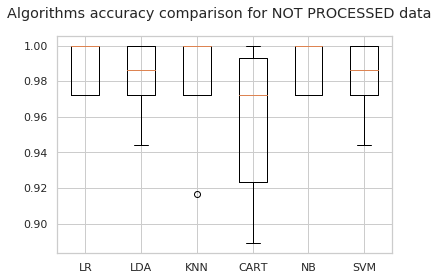

For RESCALED data we produced:

         accuracy    neg_log_loss
LR    94.17±4.02     -40.59±3.21
LDA   98.33±1.84       -3.1±2.71
KNN   98.33±1.84      -4.51±3.33
CART  96.67±3.24  -124.72±113.92
NB    98.89±1.36      -3.87±3.44
SVM   98.89±1.36      -10.1±2.51 




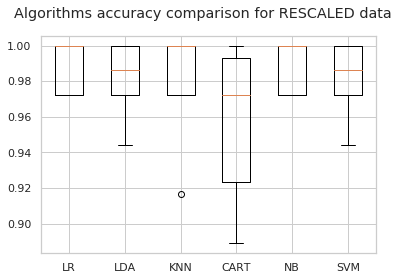

For STANDARDIZED data we produced:

         accuracy    neg_log_loss
LR    98.06±1.78     -15.09±3.59
LDA   98.33±1.84       -3.1±2.71
KNN   97.22±2.78     -16.1±29.03
CART  96.67±3.24  -124.72±105.54
NB    98.89±1.36      -3.87±3.44
SVM   98.06±1.78     -10.57±3.21 




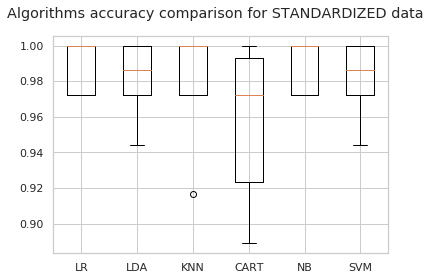

For NORMALIZED data we produced:

          accuracy   neg_log_loss
LR    73.61±12.56    -70.38±2.15
LDA    97.78±2.42      -5.63±5.4
KNN    97.22±2.48   -14.49±28.11
CART   93.33±4.34  -201.48±163.1
NB     97.78±2.42     -7.48±8.43
SVM    97.78±2.42     -11.1±4.01 




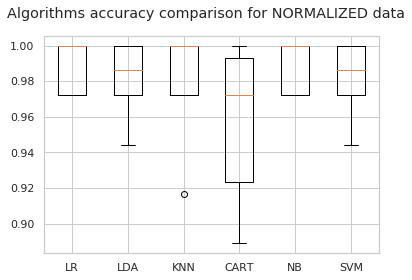

The overall best performance was the one obtained with NOT PROCESSED data, using LR algorithm. 
It's Accuracy resulted to be 98.89 with a standard deviation of 1.36


In [16]:
# prepare models
models = []
models.append(( 'LR'   , LogisticRegression(max_iter=10000)))
models.append(( 'LDA'  , LinearDiscriminantAnalysis()))
models.append(( 'KNN'  , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB'   , GaussianNB()))
models.append(( 'SVM'  , SVC(probability=True)))
results = []
names = []
higher_acc=0
standard=0
best_model=''
for process in pre_processing:
    globals()['df_'+process[0]] = pd.DataFrame(index=None, columns=None)
    for algo in models:
        estimators = [process,algo]
        model = Pipeline(estimators)
        ss = ShuffleSplit(n_splits=10, test_size=test_size, random_state=seed)
        names.append(algo[0])
        for scoring in performance_metrix:
            cv_results = cross_val_score(model, X_train, Y_train, cv=ss, scoring=scoring)
            globals()['df_'+process[0]].loc[algo[0],scoring]= '%s\u00B1%s'%(round(cv_results.mean()*100.0,2),round(cv_results.std()*100.0,2))
            if performance_metrix.index(scoring)==0:
                results.append(cv_results)
            if cv_results.mean()*100.0 > higher_acc:
                higher_acc=cv_results.mean()*100.0
                standard=cv_results.std()*100.0
                best_model=process[0], algo[0]
                
            elif cv_results.mean()*100.0 == higher_acc:
                if cv_results.std()*100.0 < standard:
                    higher_acc=cv_results.mean()*100.0
                    best_model=process[0], algo[0]
            
                    
            
    print('For %s data we produced:\n\n'%(process[0]),globals()['df_'+process[0]],'\n\n')

    # boxplot algorithm comparison
    fig = pyplot.figure()
    fig.suptitle('Algorithms accuracy comparison for %s data'%(process[0]))
    ax = fig.add_subplot(111)
    pyplot.boxplot(results[:len(models)])
    ax.set_xticklabels(names)
    pyplot.show()

# Create a pipeline that standardizes the data then creates a model
print("The overall best performance was the one obtained with %s data, using %s algorithm. \nIt's Accuracy resulted to be %s with a standard deviation of %s" %(best_model[0],best_model[1],round(higher_acc,2),round(standard,2)))


## Classification Report
gives representation of the main classification metrics .

In [17]:
# evaluation of the best model (NOT PROCESSED data, using LR algorithm) on the test set
model = LogisticRegression(max_iter=10000)
# fit on whole training test
model.fit(X_train, Y_train)
pred = model.predict(X_test)
report = classification_report(Y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.86      0.92        14
           2       0.86      1.00      0.92        12

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36



## Confusion matrix
the iris project is a multi-class classification problem with 3 classes. Thus,in order to measure the performance of our model we computed a 3-class-confusion matrix ( 3x3 matrix for calculating the performance of a prediction methods).
The diagonal elements represent the number of good predictions (eg: an iris setosa has been predicted as iris), while off-diagonal elements are the ones that have been misclassified. 

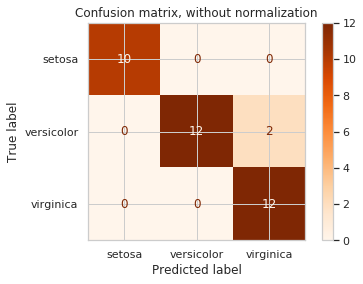

In [18]:
matrix = confusion_matrix(Y_test, pred)  
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, Y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Oranges,
                                 normalize=normalize)
    disp.ax_.set_title(title)


plt.show()

## ROC curve 
(Receiver Operating Characteristic) is a performance measurement for classification problem-
 On each axes is represented the sensibility (TPR= true positive rate) and the specificity (FPR= false positive rate).
The resulting curve shows immediately what is the dependency between these two measures in our data.
The model we generated is reliable if the AUC (area under the curve) is computed near 1.

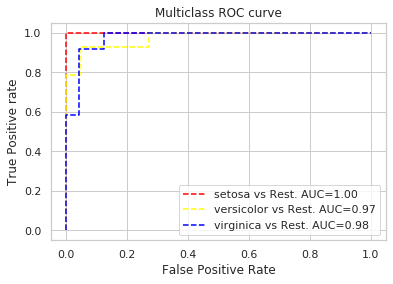

In [19]:
# fit model
clf = OneVsRestClassifier(model)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc ={}
colors=['red', 'yellow', 'blue']

for i in range(len(class_names)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, pred_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting   

    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label='%s vs Rest. AUC=%.2f'%(class_names[i],roc_auc[i]))
  
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  


## Results
From the analysis of the performance carried out for the model trained with Logistic Regression algorithm,
appears that it performs a very good overall prediction. The species that it classifies the best is setosa.